In [96]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


In [97]:
# Lectura de los datos csv
df = pd.read_csv('IPC Bienes no durables.csv')

In [98]:
# Se nombran las columnas
df.columns = ['Fecha', 'Indicador IPC']

In [99]:
# Conversion de fechas a formato aceptado por Prophrt
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y', errors='coerce')
df['Indicador IPC'] = pd.to_numeric(df['Indicador IPC'], errors='coerce')

In [100]:
print("Valores nulos:\n", df.isnull().sum())

# Eliminar filas con valores nulos
df = df.dropna()

Valores nulos:
 Fecha            0
Indicador IPC    0
dtype: int64


In [101]:
# Elimina datos duplicados
duplicates = df[df.duplicated(subset='Fecha')]
print("Fechas duplicadas:\n", duplicates)

Fechas duplicadas:
 Empty DataFrame
Columns: [Fecha, Indicador IPC]
Index: []


In [102]:
print("Estadísticas descriptivas de 'Indicador':\n", df['Indicador IPC'].describe())

Estadísticas descriptivas de 'Indicador':
 count    188.000000
mean      98.830000
std       27.482818
min       69.240000
25%       77.107500
50%       94.295000
75%      106.922500
max      167.950000
Name: Indicador IPC, dtype: float64


In [103]:
df['gap'] = df['Fecha'].diff().dt.days
print("Días entre cada registro:\n", df['gap'].describe())

Días entre cada registro:
 count    187.000000
mean      30.433155
std        0.822775
min       28.000000
25%       30.000000
50%       31.000000
75%       31.000000
max       31.000000
Name: gap, dtype: float64


In [104]:
# Configuraciones varias para muestreo de gráficos
df = df.drop(columns='gap') 

In [105]:
# Entrenamiento del modelo y renombre de nombre de columnas para los graficos
model = Prophet()
model.fit(df.rename(columns={'Fecha': 'ds', 'Indicador IPC': 'y'})) 

15:10:31 - cmdstanpy - INFO - Chain [1] start processing
15:10:31 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
# Hacer predicciones para los próximos 72 meses
future = model.make_future_dataframe(periods=72, freq='M')

c:\Users\John Sora Autentic\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [107]:
#Ejecutamos prediccion
forecast = model.predict(future)

In [108]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

            ds        yhat  yhat_lower  yhat_upper
0   2009-01-01   68.588177   66.740461   70.560541
1   2009-02-01   68.982124   66.851595   71.118933
2   2009-03-01   69.602424   67.436230   71.536934
3   2009-04-01   69.975155   67.845548   71.936225
4   2009-05-01   70.174543   68.265730   72.179322
..         ...         ...         ...         ...
255 2030-03-31  284.986696  267.413671  301.821639
256 2030-04-30  286.326469  267.643039  303.342491
257 2030-05-31  287.549155  268.435119  304.682417
258 2030-06-30  289.104731  269.606644  307.555187
259 2030-07-31  291.699681  271.626615  309.641762

[260 rows x 4 columns]


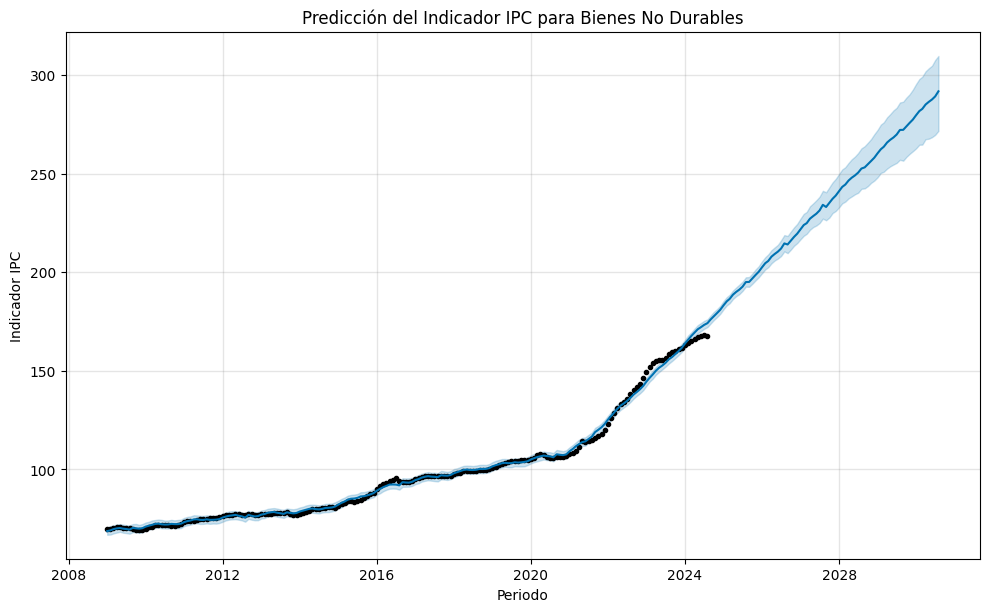

In [109]:
# Grafico de predicciones
fig = model.plot(forecast)
plt.title('Predicción del Indicador IPC para Bienes No Durables')
plt.xlabel('Periodo')  # Cambiar el nombre del eje X
plt.ylabel('Indicador IPC')  # Cambiar el nombre del eje Y

plt.show()

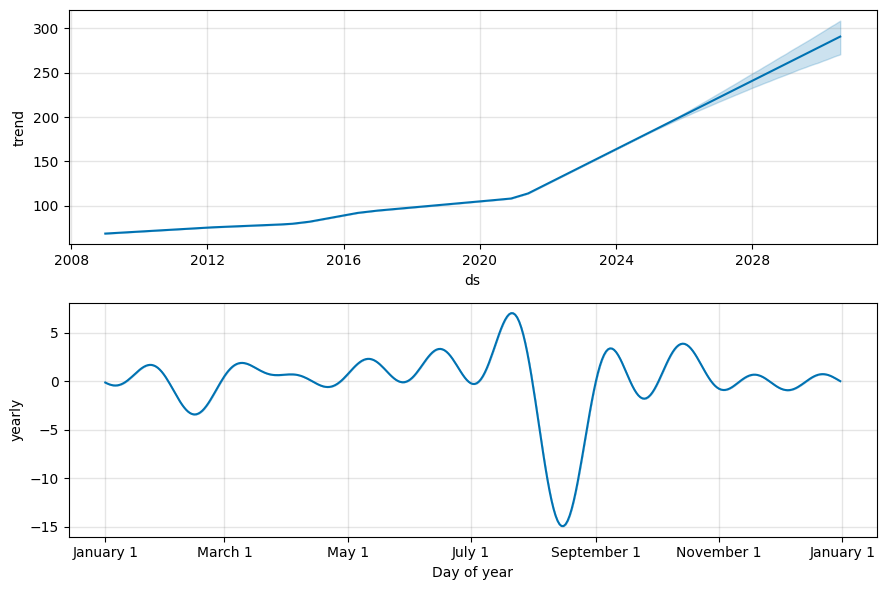

In [110]:
# Tendencia y estacionalidad
fig2 = model.plot_components(forecast)
plt.show()

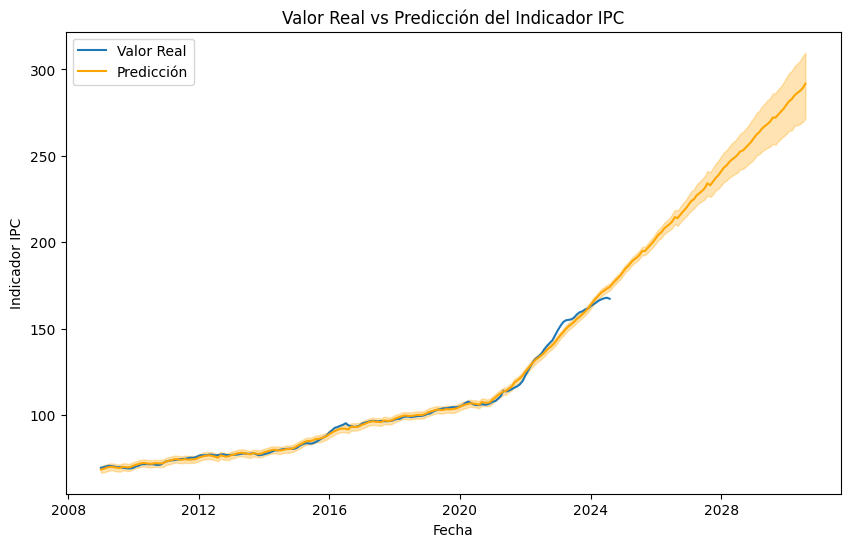

In [111]:
# Visualizar valores reales frente a predicciones
plt.figure(figsize=(10, 6))
plt.plot(df['Fecha'], df['Indicador IPC'], label='Valor Real')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicción', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
plt.title('Valor Real vs Predicción del Indicador IPC')
plt.xlabel('Fecha')
plt.ylabel('Indicador IPC')
plt.legend()
plt.show()


In [112]:
# Detectar anomalías donde el valor real del IPC se desvía significativamente de las predicciones
df_merged = pd.merge(df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], left_on='Fecha', right_on='ds', how='left')
# Ajustar el factor de sensibilidad para la detección de anomalías
df_merged['anomaly'] = abs(df_merged['Indicador IPC'] - df_merged['yhat']) > 1.2 * (df_merged['yhat_upper'] - df_merged['yhat_lower'])



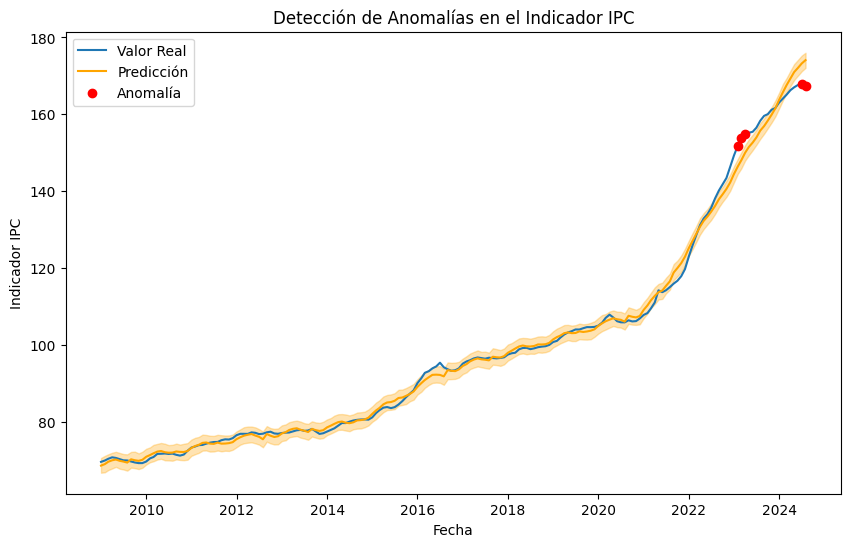

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(df_merged['Fecha'], df_merged['Indicador IPC'], label='Valor Real')
plt.plot(df_merged['ds'], df_merged['yhat'], label='Predicción', color='orange')
plt.scatter(df_merged[df_merged['anomaly']]['Fecha'], df_merged[df_merged['anomaly']]['Indicador IPC'], color='red', label='Anomalía', zorder=5)
plt.fill_between(df_merged['ds'], df_merged['yhat_lower'], df_merged['yhat_upper'], color='orange', alpha=0.3)
plt.title('Detección de Anomalías en el Indicador IPC')
plt.xlabel('Fecha')
plt.ylabel('Indicador IPC')
plt.legend()
plt.show()